# Create and run a local RAG pipeline from scratch

## What is Retrieval Augmented Generation (RAG)?

The goal of RAG is to take local information and pass it to an LLM so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "what are the macronutrients and what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.
* Augmented - We want to take the relevant information and augment our input (prompt) to an LLM with that relevant information.
* Generation - Take the first two steps and pass them to an LLM for generative outputs.

If you want to read where RAG came from, see the paper from Facebook AI: https://arxiv.org/abs/2005.11401


## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text doesn't mean that it's factual. RAG can help LLMs generate information based on relevant passages that are factual.
2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).

## What we're going to build

We're going to build a sample LLM based on a large PDF, so we can "chat with a nutrition textbook".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical reprentations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

### What you need....
You (or a member of your group) need to sign up (free) to HuggingFace to get access to a free LLM model called "gemma-7b-it").

https://huggingface.co/google/gemma-7b-it


## Assumptions

1. You have some basic Python experience
2. You have heard about/used Pytorch
3. You're curious about LLM's and want ot explore

## Check Requirements

Let's make sure your environment can handle this. Since this is on google colab, we know it can!

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 21.3 MB/s e

## 1. Document/text processing and embedding creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, I've just chosen to focus on PDFs for now).
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

In [2]:
#import os
import requests
import sys
import re
import random
import pandas as pd
import numpy as np


from google.colab import drive #give colab access to google drive...
from google.colab import auth

drive.mount('/content/drive')
thePath = '/content/drive/MyDrive/RAGContent/'
theFile = "Human-Nutrition-2020.pdf"

# Download PDF
if os.path.exists(thePath + theFile):
  print("\n[INFO] file exists!")
else:
  print(f"\n[INFO] {thePath+theFile} not found!")



MessageError: Error: credential propagation was unsuccessful

In [ ]:
# let's open the PDF and read the text from the pages...

import fitz # requires: !pip install PyMuPDF, see: https://github.com/pymupdf/PyMuPDF
from tqdm.auto import tqdm # pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(aPath: str) -> list[dict]:
    doc = fitz.open(aPath)
    skip_front_pages = 41
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - skip_front_pages,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_setence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 characters
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(thePath+theFile)
print(pages_and_texts[:2])
print("Number of pages: ", len(pages_and_texts))

0it [00:00, ?it/s]

[{'page_number': -41, 'page_char_count': 29, 'page_word_count': 4, 'page_setence_count_raw': 1, 'page_token_count': 7.25, 'text': 'Human Nutrition: 2020 Edition'}, {'page_number': -40, 'page_char_count': 0, 'page_word_count': 1, 'page_setence_count_raw': 1, 'page_token_count': 0.0, 'text': ''}]
Number of pages:  1208


In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 76,
  'page_char_count': 1222,
  'page_word_count': 205,
  'page_setence_count_raw': 10,
  'page_token_count': 305.5,
  'text': '“Histology  Small  Intestines” by  OpenStax  College / CC  BY 3.0  area to maximize nutrient absorption. The surface area is increased  by folds, villi, and microvilli. Digested nutrients are absorbed into  either capillaries or lymphatic vessels contained within each  microvillus.  The small intestine is perfectly structured for maximizing  nutrient absorption. Its surface area is greater than 200 square  meters, which is about the size of a tennis court. The large surface  area is due to the multiple levels of folding. The internal tissue  of the small intestine is covered in villi, which are tiny finger-like  projections that are covered with even smaller projections, called  microvilli (Figure 2.8 “Structure of the Small Intestine”). The  digested nutrients pass through the absorptive cells of the intestine  via diffusion or special trans

### Let's show some statistics about our document...

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why would we care about token count?

Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/pretrained_models.html).

As for LLMs, they can't accept infinite tokens in their context window, plus it would be cost ineffective to send 100,000s of tokens to an LLM every time.

We want the tokens we send to an LLM to valuable tokens.

### Further text processing (splitting pages into sentences)

Now break the text into chunks of sentences, groups of 5, 7, 10 or more sentences (TBD).

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage).

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

In [ ]:
pages_and_texts[50]

{'page_number': 9,
 'page_char_count': 1320,
 'page_word_count': 215,
 'page_setence_count_raw': 4,
 'page_token_count': 330.0,
 'text': 'Minerals  Major Functions  Macro  Sodium  Fluid balance, nerve transmission, muscle contraction  Chloride  Fluid balance, stomach acid production  Potassium  Fluid balance, nerve transmission, muscle contraction  Calcium  Bone and teeth health maintenance, nerve transmission,  muscle contraction, blood clotting  Phosphorus  Bone and teeth health maintenance, acid-base balance  Magnesium  Protein production, nerve transmission, muscle  contraction  Sulfur  Protein production  Trace  Iron  Carries oxygen, assists in energy production  Zinc  Protein and DNA production, wound healing, growth,  immune system function  Iodine  Thyroid hormone production, growth, metabolism  Selenium  Antioxidant  Copper  Coenzyme, iron metabolism  Manganese  Coenzyme  Fluoride  Bone and teeth health maintenance, tooth decay  prevention  Chromium  Assists insulin in glucose

In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")  #add sentencizer pipeline

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 946,
  'page_char_count': 1757,
  'page_word_count': 313,
  'page_setence_count_raw': 17,
  'page_token_count': 439.25,
  'text': 'workout four to five days per week, you can become more active in  simple ways—by taking the stairs instead of the elevator, by walking  more instead of driving, by going out dancing with your friends, or  by doing your household chores at a faster pace. It is not necessary  to perform at the level of a professional dancer or athlete, or to work  out for several hours every day, to see real gains from exercise. Even  slightly increased activity can lead to physical benefits, such as:  • Longer life. A regular exercise program can reduce your risk of  dying early from heart disease, certain cancers, and other  leading causes of death.  • Healthier weight. Exercise, along with a healthy, balanced  eating plan, can help you lose extra weight, maintain weight  loss, or prevent excessive weight gain.  • Cardiovascular disease prevention. Being a

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We'll keep it simple and split into groups of 10 sentences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as LangChain which can help with this, however, we'll stick with Python for now: https://python.langchain.com/docs/modules/data_connection/document_transformers/

Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect that large passages of text).
2. So our text chunks can fit into our embedding model context window (e.g. 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused.

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

    # Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])


  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 161,
  'page_char_count': 610,
  'page_word_count': 100,
  'page_setence_count_raw': 4,
  'page_token_count': 152.5,
  'text': 'Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=139  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=139  Water’s Importance to Vitality  |  161',
  'sentences': ['Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Ch

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


## Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
# show a random sample...
random.sample(pages_and_chunks, k=1)

[{'page_number': 205,
  'sentence_chunk': 'product development, food reformulation), and information/ education strategies for the public and professionals.”7 Try for Yourself The National Heart, Lung, and Blood Institute has prepared an informative fact sheet on the DASH diet: http://www.nhlbi.nih.gov/health/public/heart/hbp/ dash/new_dash.pdf. Use the food-group charts to help design a daily menu that follows the DASH eating plan. 7.\xa0Henney JE, Taylor CL, Boon CS. (2010). Strategies to Reduce Sodium Intake in the United States, by Committee on Strategies to Reduce Sodium Intake, Institute of Medicine. Washington, D. C.: National Academies Press.\xa0http://www.nap.edu/ openbook.php?record_id=12818&page= 19#p2001bcf59960019001. Accessed September 22, 2017.',
  'chunk_char_count': 720,
  'chunk_word_count': 90,
  'chunk_token_count': 180.0}]

In [ ]:
# Show some stats about our chunks...
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filter chunks of text for short chunks

Some of these chunks may not contain much useful information. Grab those with more than 30 tokens.

In [ ]:
# Show random chunks with under 30 tokens in length
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows(): # Changed "page_token_count" to "chunk_token_count"
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}') # Changed "page_token_count" to "chunk_token_count"

Chunk token count: 16.25 | Text: Health Consequences and Benefits of High-Carbohydrate Diets | 267
Chunk token count: 16.25 | Text: Updated January 2015. Accessed December 4, 2017. Middle Age | 917
Chunk token count: 6.5 | Text: Fat-Soluble Vitamins | 539
Chunk token count: 13.0 | Text: PART VII CHAPTER 7. ALCOHOL Chapter 7. Alcohol | 429
Chunk token count: 7.25 | Text: Human Nutrition: 2020 Edition


### Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [ ]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 249,
  'sentence_chunk': 'Foods GI Value Low GI Foods (< 55) Apple, raw 36 Orange, raw 43 Banana, raw 51 Mango, raw 51 Carrots, boiled 39 Taro, boiled 53 Corn tortilla 46 Spaghetti (whole wheat) 37 Baked beans 48 Soy milk 34 Skim milk 37 Whole milk 39 Yogurt, fruit 41 Yogurt, plain 14 Icecream 51 Medium GI Foods (56–69) Pineapple, raw 59 Cantaloupe 65 Mashed potatoes 70 Whole-wheat bread 69 Brown rice 55 Cheese pizza 60 Sweet potato, boiled 63 Macaroni and cheese 64 Popcorn 65 High GI Foods (70 and higher) Banana (over-ripe) 82 Corn chips 72 Digestion and Absorption of Carbohydrates | 249',
  'chunk_char_count': 569,
  'chunk_word_count': 103,
  'chunk_token_count': 142.25}]

## Embedding our text chunks

Embeddings are a broad but powerful concept. Embeddings are a "learned numerical representation" of our content.

Let's turn our text chunks into embeddings.

```
{"the": 0,
"a": 1,
...
```

## For a great resource on learning embeddings, see here: https://vickiboykis.com/what_are_embeddings/

In [ ]:
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")


from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")


device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44285630e-02  2.95328591e-02 -2.33643278e-02  5.57256751e-02
 -2.19098292e-02 -6.47057872e-03  1.02849491e-02 -6.57803565e-02
  2.29717810e-02 -2.61120535e-02  3.80421057e-02  5.61402440e-02
 -3.68746333e-02  1.52787715e-02  4.37020734e-02 -5.19723631e-02
  4.89479341e-02  3.58107197e-03 -1.29750511e-02  3.54383001e-03
  4.23261970e-02  3.52606773e-02  2.49401834e-02  2.99177319e-02
 -1.99381653e-02 -2.39752606e-02 -3.33374622e-03 -4.30450067e-02
  5.72014078e-02 -1.32517768e-02 -3.54477949e-02 -1.13936048e-02
  5.55561371e-02  3.61095252e-03  8.88527211e-07  1.14027308e-02
 -3.82229686e-02 -2.43545324e-03  1.51313748e-02 -1.32657966e-04
  5.00659905e-02 -5.50876968e-02  1.73444636e-02  5.00958823e-02
 -3.75959389e-02 -1.04463827e-02  5.08322865e-02  1.24861021e-02
  8.67376328e-02  4.64143157e-02 -2.10690182e-02 -3.90251763e-02
  1.99696166e-03 -1.42345810e-02 -1.86795164e-02  2.826696

In [ ]:
# our sentences have become "embeddings".
embeddings[0].shape

(768,)

Why do we have the shape,  (768)?

In [ ]:
%%time

import torch
import numpy as np

print(f"device {device}")

embedding_model.to(device)

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

device cuda


  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 36.4 s, sys: 442 ms, total: 36.8 s
Wall time: 42.4 s


In [ ]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Check if the index is within the valid range
index_to_access = len(text_chunks)-1
print(text_chunks[index_to_access])


23. Vitamin D reused “The Functions of Vitamin D” by Allison Calabrese / Attribution – Sharealike 24. Vitamin K reused “Kale Lacinato Lacinato Kale” by BlackRiv / Pixabay License; “Phylloquinone structure” by Mysid / Public Domain 1166 | Attributions
CPU times: user 1.22 ms, sys: 15 µs, total: 1.24 ms
Wall time: 1.34 ms


In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can experiment to find which batch size leads to best results
                                               convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 20.8 s, sys: 104 ms, total: 20.9 s
Wall time: 24.5 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

For this notebook, we just save embedding to a local file (in the notebook container). But in the real world, we would save these to a vector database that is optimized to process vectors.



In [ ]:
print(len(pages_and_chunks_over_min_token_len))
pages_and_chunks_over_min_token_len[107]

1680


{'page_number': 48,
 'sentence_chunk': 'that painlessly samples your blood, and downloads the information to your cell phone, which has an app that evaluates the nutrient profile of your blood and then recommends a snack or dinner menu to assure you maintain adequate nutrient levels. What else is not far off?How about another app that provides a shopping list that adheres to all dietary guidelines and is emailed to the central server at your local grocer, who then delivers the food to your home?The food is then stored in your smart fridge which documents your daily diet at home and delivers your weekly dietary assessment to your home computer. At your computer, you can compare your diet with other diets aimed at weight loss, optimal strength training, reduction in risk for specific diseases or any other health goals you may have. You also may delve into the field of nutritional genetics and download your gene expression profiles to a database that analyzes your genes against millions o

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_path, index=False)

In [ ]:
# Import saved file and view
#embeddings_path = "text_chunks_and_embeddings_df.csv" #put here too so we can start here...
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


<hr>

# 2. RAG - Search and Answer

RAG goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or *vibe*.

So if I search for "macronutrients functions" I should get relevant passages to that text but may not contain exactly the words "macronutrient functions".

Whereas with keyword search, if I search "apple" I get back passages with specifically "apple".


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

embeddings[0]



tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [ ]:
embeddings.shape
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [ ]:

# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding model ready!

Let's create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "macronutrient functions") and get back relevant passages from our textbook.

We can do so with the following steps:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.

In [ ]:
embeddings.shape

torch.Size([1680, 768])

Note: to use dot product for comparison, ensure vector sizes are of same shape (e.g. 768) and tensors/vectors are in the same datatype (e.g. both are in torch.float32).

In [ ]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's import to embed you query with the same model you embedding your passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to get scores on 1680 embeddings: 0.02553 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across our embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings: 0.00126 seconds.


We can see that searching over embeddings is very fast even if we do exhaustive.

But if you had 10M+ embeddings, you likely want to create an index.

An index is like letters in the dictionary.

For example, if you wanted to search "duck" in the dictionary, you'd start at "d" then find words close to "du..." etc.

An index helps to narrow it down.

A populary indexing library for vector search is Faiss, see here: https://github.com/facebookresearch/faiss

One technique that the library provides is approximate nearest neighbour search (ANN): https://en.wikipedia.org/wiki/Nearest_neighbor_search

Let's make our vector search results pretty.

In [ ]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")


Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

Note: We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

See here for an open-source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

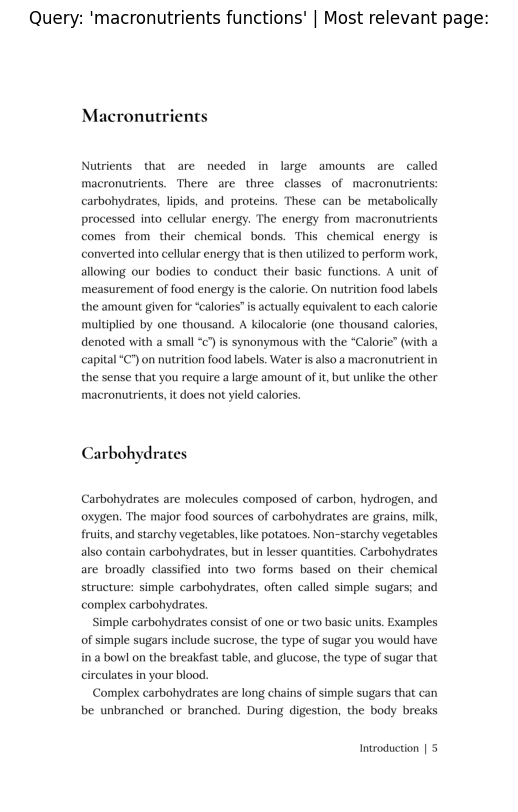

In [ ]:
import fitz # pymupdf library

# open PDF and load target
#pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(thePath+theFile)

theFrontMatterLen = 41
page = doc.load_page(5 + theFrontMatterLen) # note: page numbers of our PDF start 6+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction (which way is it going?) and magnitude (how long is it?).

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


## Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a functionor two so we can repeat the workflow.

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [ ]:
query = "symptoms of pellagra"
# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (1680 embeddings: 0.00007 seconds.
Score: 0.5000
Text:
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
Text:
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with them. In the
United States,

### Getting an LLM for local generation

We want to focus on local genertion.

However, this process will also work with an LLM API.

What is a generative LLM?

Goes from text input -> generate text output.

Which LLM should I use?

* How much hardware VRAM do you have available?

### Checking our local GPU memory availability

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


Notes:
* to use `gemma-7b-it` or other Gemma models, you have to accept terms & conditions on Hugging Face: https://huggingface.co/google/gemma-7b-it
* to download models and run locally from Hugging Face, you may need to sign in to the Hugging Face CLI: https://huggingface.co/docs/huggingface_hub/en/guides/cli

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally

We can load an LLM locally using Hugging Face `transformers`.

The model I'm going to use on my NVIDIA RTX 4090 - https://huggingface.co/google/gemma-7b-it

To get a model running local we're going to need a few things:
1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
2. A model ID - this will tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
4. An LLM model - this will be what we use to generate text based on an input!

> **Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention


### Now - Log into HuggingFace

In [ ]:
from huggingface_hub import login
login(token=os.getenv('HugFaceGemma'))

In [ ]:
#install accelerate package
!pip install bitsandbytes accelerate

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available


# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

We got the size our model.

This means to load Gemma 7b-it in float16 we need a minimum of 16GB of VRAM, however due to the calculations that take place in the forward pass, we actually need closer to 19GB.

### Generating text with our LLM

Let's generate text with our local LLM!

* Note: Some models have been trained/tuned to generate text with a specific template in mind.

Because `gemma-7b-it` has been trained in an instruction-tuned manner, we should follow the instruction template for the best results.

In [ ]:
input_text = "What are the macronutrients and what are their functions in the body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients and what are their functions in the body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model



In [ ]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592,    578,   1212,    708,   1024,   7257,    575,    573,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  25497,    576,    573, 186809, 184592,    578,
          1024,   7257,    575,    573,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109, 235287,   5231, 156615,  56227,  66058,
           108,    141, 235287,  34428,   4134,    604,    573,   2971, 235303,
        235256,   5999,    578,  29703, 235265,    108,    141, 235287, 110165,
         56227,    708,    573,   2971, 235303, 235256,   1872,   4303,    576,
          4134, 235269,   5199,   2290,   6915,   5640, 235265,    108,    141,
        235287,  25280,  72780,   3707,   2343,   2127, 235269,  38317, 235269,
           578,  84475, 235265,    108, 235287,   5231,  49471,  66058,    108,
           141, 2

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their functions in the body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the body's main source of energy, especially during physical activity.
    * Complex carbohydrates include starches, fibers, and sugars.
* **Protein:**
    * Builds and repairs tissues, enzymes, and hormones.
    * Protein is essential for muscle growth and repair, as well as for the production of antibodies.
    * Complete proteins include animal products, legumes, nuts, and seeds.
* **Fat:**
    * Provides energy, insulation, and the production of hormones.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the risk of heart disease.

**Functions of Macronutri

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: water soluble vitamins
[INFO] Time taken to get scores on (1680 embeddings: 0.00033 seconds.


(tensor([0.7893, 0.7625, 0.7386, 0.7099, 0.6996], device='cuda:0'),
 tensor([855, 801, 756, 755, 848], device='cuda:0'))

### Augmenting our prompt with context items

We've done retrieval.

We've done generation.

Time to augment!

The concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out.

However, there are a fair few techniques that work quite well.

Resources:
* https://www.promptingguide.ai/
* https://github.com/brexhq/prompt-engineering
* https://www.anthropic.com/news/prompt-engineering-for-business-performance

We're going to use a couple of prompting technqiues:
1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...".

Let's create a function to format a prompt with context items.

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)

    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on (1680 embeddings: 0.00015 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K

Prompt example:

```
Based on the following contexts:
- sdjfhasdfjh
- dfhsdlfj
- sdfsdakfjaslkjf
- iwqewiurbndf
- dsfsd;fadskjfh

Please answer the following query: What are the macronutrients and what do they do?
Answer:
```

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text, the higher the value, the more creative
                             do_sample=True, # whether or not to use sampling, https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

Query: What role does fibre play in digestion? Name five fibre containing foods.
RAG answer:\m<bos>Relevant passages:

"Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados. Functional fibers have been added to foods and have been shown to provide health benefits to humans. Functional fibers may be extracted from plants and purified or synthetically made."<eos>
CPU times: user 5.34 s, sys: 18 ms, total: 5.36 s
Wall time: 5.83 s


### Functionize our LLM answering feature

Wouldn't it be cool if our RAG pipeline worked from a single function?

E.g. you input a query and you get a generated answer + optionally also get the source documents (the context) where that answer was generated from.

Let's make a function to do it!

In [ ]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query,
    temperature=0.2,
    return_answer_only=False)

Query: How does saliva help with digestion?
[INFO] Time taken to get scores on (1680 embeddings: 0.00009 seconds.


('The passage does not provide any information about how saliva helps with digestion, so I cannot answer this question from the context.',
 [{'page_number': 240,
   'sentence_chunk': 'Digestion and Absorption of Carbohydrates UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM From the Mouth to the Stomach The mechanical and chemical digestion of carbohydrates begins in the mouth. Chewing, also known as mastication, crumbles the carbohydrate foods into smaller and smaller pieces. The salivary glands in the oral cavity secrete saliva that coats the food particles. Saliva contains the enzyme, salivary amylase. This enzyme breaks the bonds between the monomeric sugar units of disaccharides, oligosaccharides, and starches. The salivary amylase breaks down amylose and amylopectin into smaller chains of glucose, called dextrins and maltose. The increased concentration of maltose in the mouth that results from the mechanical and chemical breakdo

## Summary

* RAG = powerful technique for generating text based on reference documents.
* Doesn't have to be too complicated to setup. We've just built one from scratch running on our local machines that can run in 3-4 functions.
* Hardware use = use GPU where possible to accelerate embedding creation and LLM generation.
    * Keep in mind the limitations on your local hardware.
* Many open-source embedding models and LLMs starting to became available, keep experimenting to find which is best.
* Semantic search is a really helpful tool.